

```
# This is formatted as code
```

### DATA EXPLORATION

In [ ]:
import os
import math
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import geopy.distance
from tqdm import tqdm
from IPython.display import display
from statsmodels.formula import api
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('uber.csv')

df.drop(['Unnamed: 0','key'], axis=1, inplace=True)
display(df.head())

target = 'fare_amount'
features = [i for i in df.columns if i not in [target]]

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0



Inference: The Datset consists of 7 features & 134080 samples.


In [ ]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)
df.dropna(inplace=True)

                   Total Null Values  Percentage
fare_amount                        0         0.0
pickup_datetime                    0         0.0
pickup_longitude                   0         0.0
pickup_latitude                    0         0.0
passenger_count                    1         0.0
dropoff_longitude                  2         0.0
dropoff_latitude                   2         0.0


In [ ]:
# Reframing the columns

df = df[(df.pickup_latitude<90) & (df.dropoff_latitude<90) &
        (df.pickup_latitude>-90) & (df.dropoff_latitude>-90) &
        (df.pickup_longitude<180) & (df.dropoff_longitude<180) &
        (df.pickup_longitude>-180) & (df.dropoff_longitude>-180)]

df.pickup_datetime=pd.to_datetime(df.pickup_datetime)

df['year'] = df.pickup_datetime.dt.year
df['month'] = df.pickup_datetime.dt.month
df['weekday'] = df.pickup_datetime.dt.weekday
df['hour'] = df.pickup_datetime.dt.hour

df['Monthly_Quarter'] = df.month.map({1:'Q1',2:'Q1',3:'Q1',4:'Q2',5:'Q2',6:'Q2',7:'Q3',
                                      8:'Q3',9:'Q3',10:'Q4',11:'Q4',12:'Q4'})
df['Hourly_Segments'] = df.hour.map({0:'H1',1:'H1',2:'H1',3:'H1',4:'H2',5:'H2',6:'H2',7:'H2',8:'H3',
                                     9:'H3',10:'H3',11:'H3',12:'H4',13:'H4',14:'H4',15:'H4',16:'H5',
                                     17:'H5',18:'H5',19:'H5',20:'H6',21:'H6',22:'H6',23:'H6'})

df['Distance']=[round(geopy.distance.distance((df.pickup_latitude[i], df.pickup_longitude[i]),(df.dropoff_latitude[i], df.dropoff_longitude[i])).m,2) for i in df.index]

df.drop(['pickup_datetime','month', 'hour',], axis=1, inplace=True)

original_df = df.copy(deep=True)

df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,Distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,3,Q3,H5,4483.73


In [ ]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134070 entries, 0 to 134078
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        134070 non-null  float64
 1   pickup_longitude   134070 non-null  float64
 2   pickup_latitude    134070 non-null  float64
 3   dropoff_longitude  134070 non-null  float64
 4   dropoff_latitude   134070 non-null  float64
 5   passenger_count    134070 non-null  float64
 6   year               134070 non-null  int64  
 7   weekday            134070 non-null  int64  
 8   Monthly_Quarter    134070 non-null  object 
 9   Hourly_Segments    134070 non-null  object 
 10  Distance           134070 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 16.3+ MB


In [ ]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

Monthly_Quarter           4
Hourly_Segments           6
year                      7
weekday                   7
passenger_count           8
fare_amount            1070
pickup_longitude      59909
dropoff_longitude     63753
pickup_latitude       68710
dropoff_latitude      72903
Distance             116139
dtype: int64

In [ ]:
#Checking number of unique rows in each feature

nu = df.drop([target], axis=1).nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df.drop([target], axis=1).shape[1]):
    if nu.values[i]<=24:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 5 numerical & 5 categorical features.


In [ ]:
#Checking the stats of all the columns

display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Distance
count,134070.000000,134070.000000,134070.000000,134070.000000,134070.000000,134070.000000,134070.000000,134070.000000,1.340700e+05
mean,11.364127,-72.490709,39.911331,-72.500936,39.913620,1.680010,2011.745163,3.052853,2.150621e+04
std,9.855398,10.495536,6.175285,10.456123,6.168086,1.418114,1.856793,1.947183,3.900074e+05
min,-52.000000,-93.824668,-74.015515,-75.458979,-74.015750,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992060,40.734840,-73.991412,40.733747,1.000000,2010.000000,1.000000,1.214938e+03
50%,8.500000,-73.981812,40.752647,-73.980113,40.752971,1.000000,2012.000000,3.000000,2.123035e+03
75%,12.500000,-73.967057,40.767127,-73.963732,40.767977,2.000000,2013.000000,5.000000,3.881395e+03
max,350.000000,40.808425,47.383332,40.831932,45.031598,208.000000,2015.000000,6.000000,8.783594e+06


## EXPLORATORY DATA ANALYSIS

*   List item
*   List item



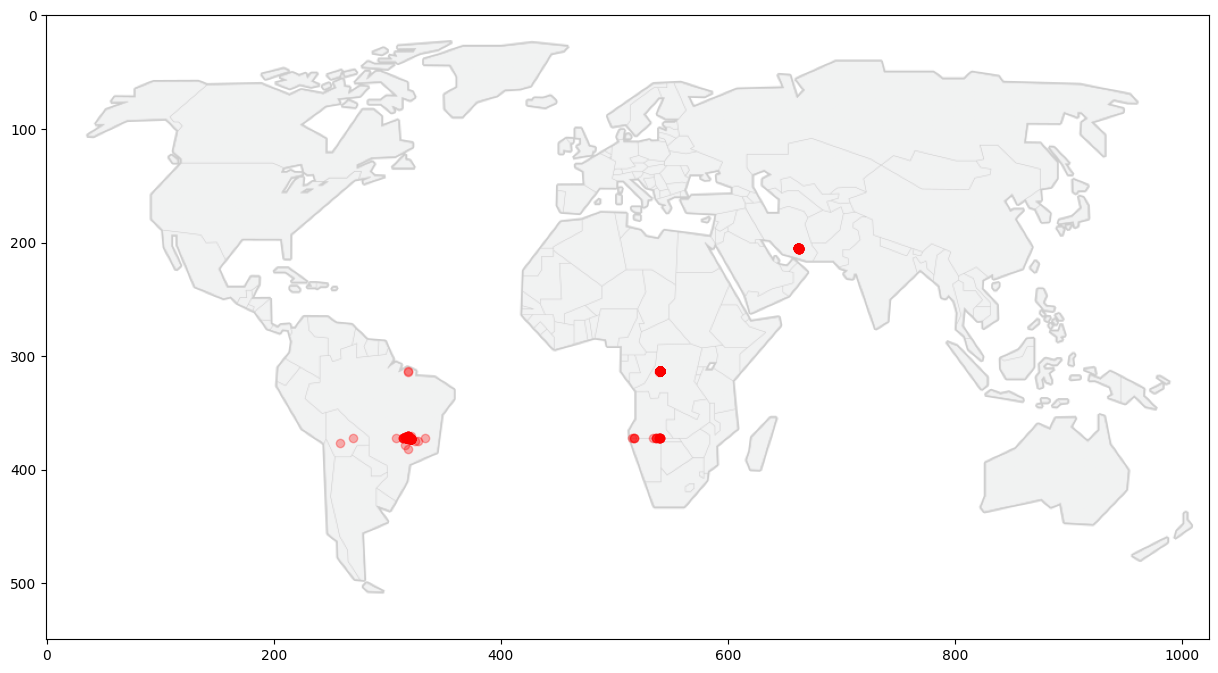

In [ ]:
plt.figure(figsize=[15,10])
a=plt.imread('wm.png')
plt.imshow(a, alpha=0.2)
plt.scatter( (df.pickup_longitude+180)*3,(df.pickup_latitude+215)*1.45555555,alpha=0.3, color='red')
plt.show()

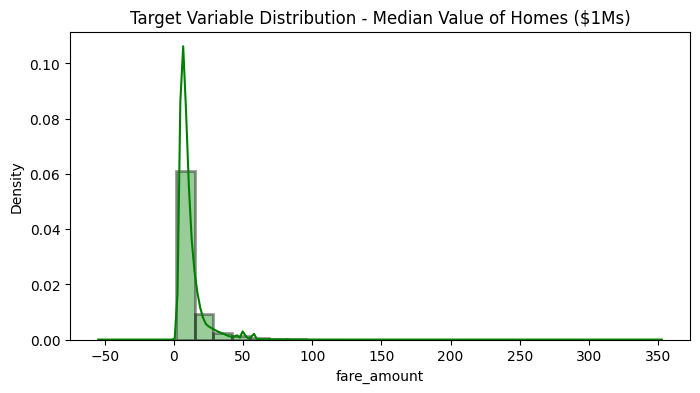

In [ ]:
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                               Visualising Categorical Features:                                


KeyboardInterrupt: 

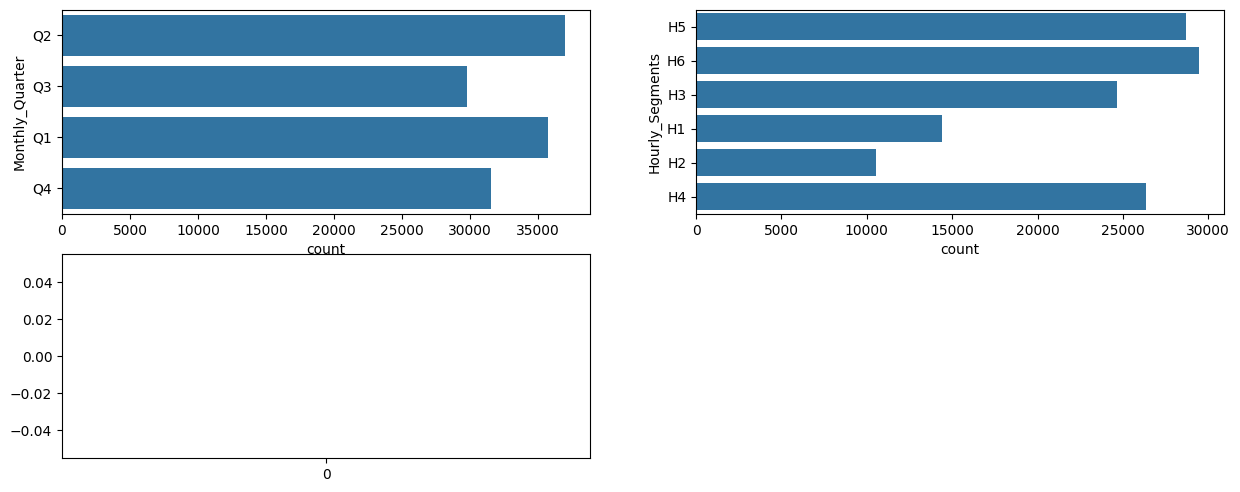

In [ ]:
print('\033[1mVisualising Categorical Features:'.center(100))

n=2
plt.figure(figsize=[15,3*math.ceil(len(cf)/n)])


for i in range(len(cf)):
    if df[cf[i]].nunique()<=12:
        plt.subplot(math.ceil(len(cf)/n),n,i+1)
        sns.countplot(df[cf[i]])

    else:
        plt.subplot(3,1,i-3)
        sns.countplot(df[cf[i]])


plt.tight_layout()
plt.show()

In [ ]:
#Visualising the numeric features

print('\033[1mNumeric Features Distribution'.center(100))

n=5

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,5*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

### DATA PREPROCESSING

In [ ]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)
df.drop(['pickup_latitude','pickup_longitude',
         'dropoff_latitude','dropoff_longitude'],axis=1)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: Number of duplicates dropped/fixed ---> 2


In [ ]:
#Converting categorical Columns to Numeric

df1 = df.copy()
df3 = df1.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]

In [ ]:
#One-Hot Binary Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)

df3.shape


Dummy Encoding on features:
Monthly_Quarter
Hourly_Segments
passenger_count
year
weekday


(35720, 32)

In [ ]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2012,year_2013,year_2014,year_2015,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,4.9,-73.969019,40.755910,-73.969019,40.755910,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0



Inference:
Before removal of outliers, The dataset had 35720 samples.
After removal of outliers, The dataset now has 29219 samples.


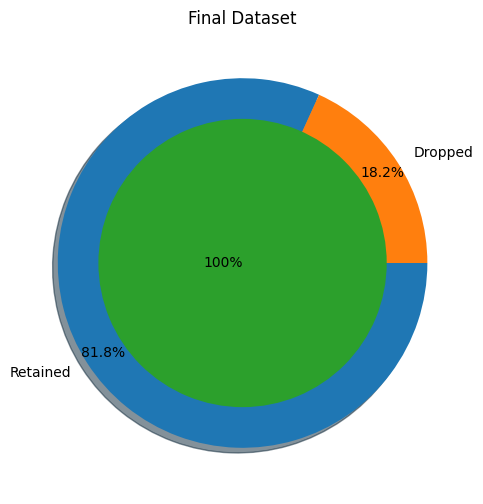


Inference: After the cleanup process, 6503 samples were dropped, while retaining 18.2% of the data.


In [ ]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False,
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

### DATA MANIPULATION

In [ ]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))

df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (29219, 31) (29219,) 
Training set  --->  (23375, 31) (23375,) 
Testing set   --->  (5844, 31)  (5844,)


In [ ]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(100))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(100))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                               Standardardization on Training set                               


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,year_2012,year_2013,year_2014,year_2015,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
count,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,...,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04,2.337500e+04
mean,4.238452e-14,-1.194788e-13,-3.596015e-13,-2.587087e-13,-1.079113e-17,8.420121e-17,-3.161345e-17,2.735780e-18,-3.009357e-17,8.511314e-18,...,2.097431e-17,3.799694e-17,6.687461e-17,-4.362048e-17,-5.866727e-17,-4.590030e-17,8.055351e-17,9.727216e-18,-1.152067e-16,2.036636e-17
std,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,...,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00,1.000021e+00
min,-2.935983e+00,-2.897389e+00,-2.904873e+00,-2.850905e+00,-1.614279e+00,-6.116460e-01,-5.337654e-01,-5.537769e-01,-2.777396e-01,-4.781024e-01,...,-4.405271e-01,-4.280010e-01,-4.132782e-01,-2.797894e-01,-4.146962e-01,-4.168901e-01,-4.199959e-01,-4.256898e-01,-4.251288e-01,-3.832039e-01
25%,-6.771145e-01,-6.888687e-01,-6.698236e-01,-6.592165e-01,-7.646864e-01,-6.116460e-01,-5.337654e-01,-5.537769e-01,-2.777396e-01,-4.781024e-01,...,-4.405271e-01,-4.280010e-01,-4.132782e-01,-2.797894e-01,-4.146962e-01,-4.168901e-01,-4.199959e-01,-4.256898e-01,-4.251288e-01,-3.832039e-01
50%,-5.904085e-02,3.646841e-02,-6.760277e-02,4.394932e-02,-2.379994e-01,-6.116460e-01,-5.337654e-01,-5.537769e-01,-2.777396e-01,-4.781024e-01,...,-4.405271e-01,-4.280010e-01,-4.132782e-01,-2.797894e-01,-4.146962e-01,-4.168901e-01,-4.199959e-01,-4.256898e-01,-4.251288e-01,-3.832039e-01
75%,6.339723e-01,6.578318e-01,6.249855e-01,6.431752e-01,5.687667e-01,1.634933e+00,-5.337654e-01,-5.537769e-01,-2.777396e-01,-4.781024e-01,...,-4.405271e-01,-4.280010e-01,-4.132782e-01,-2.797894e-01,-4.146962e-01,-4.168901e-01,-4.199959e-01,-4.256898e-01,-4.251288e-01,-3.832039e-01
max,3.221875e+00,2.797557e+00,3.117926e+00,2.796153e+00,2.908002e+00,1.634933e+00,1.873482e+00,1.805781e+00,3.600494e+00,2.091602e+00,...,2.270008e+00,2.336443e+00,2.419677e+00,3.574116e+00,2.411404e+00,2.398714e+00,2.380975e+00,2.349129e+00,2.352229e+00,2.609577e+00



                                Standardardization on Testing set                                


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,Distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,Hourly_Segments_H3,...,year_2012,year_2013,year_2014,year_2015,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
count,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,...,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000,5844.000000
mean,-0.023950,-0.025355,-0.002301,0.011262,-0.029566,0.040338,-0.016397,-0.020010,-0.005653,0.017019,...,0.013084,0.006723,-0.011410,-0.012047,0.000224,0.003716,-0.014037,0.002118,0.026833,-0.017044
std,1.001673,1.001496,0.986863,0.998386,0.984859,1.019720,0.988904,0.987276,0.990633,1.013581,...,1.011900,1.006458,0.988506,0.979965,1.000309,1.003755,0.986125,1.002119,1.025266,0.980779
min,-2.696916,-2.840884,-2.621970,-2.848993,-1.614279,-0.611646,-0.533765,-0.553777,-0.277740,-0.478102,...,-0.440527,-0.428001,-0.413278,-0.279789,-0.414696,-0.416890,-0.419996,-0.425690,-0.425129,-0.383204
25%,-0.714848,-0.716816,-0.652138,-0.641818,-0.767779,-0.611646,-0.533765,-0.553777,-0.277740,-0.478102,...,-0.440527,-0.428001,-0.413278,-0.279789,-0.414696,-0.416890,-0.419996,-0.425690,-0.425129,-0.383204
50%,-0.084231,-0.003028,-0.062189,0.051661,-0.269212,-0.611646,-0.533765,-0.553777,-0.277740,-0.478102,...,-0.440527,-0.428001,-0.413278,-0.279789,-0.414696,-0.416890,-0.419996,-0.425690,-0.425129,-0.383204
75%,0.616246,0.611554,0.595426,0.640422,0.518690,1.634933,-0.533765,-0.553777,-0.277740,-0.478102,...,-0.440527,-0.428001,-0.413278,-0.279789,-0.414696,-0.416890,-0.419996,-0.425690,-0.425129,-0.383204
max,3.184137,2.804123,3.113930,2.770751,2.905264,1.634933,1.873482,1.805781,3.600494,2.091602,...,2.270008,2.336443,2.419677,3.574116,2.411404,2.398714,2.380975,2.349129,2.352229,2.609577


                                       Correlation Matrix                                       


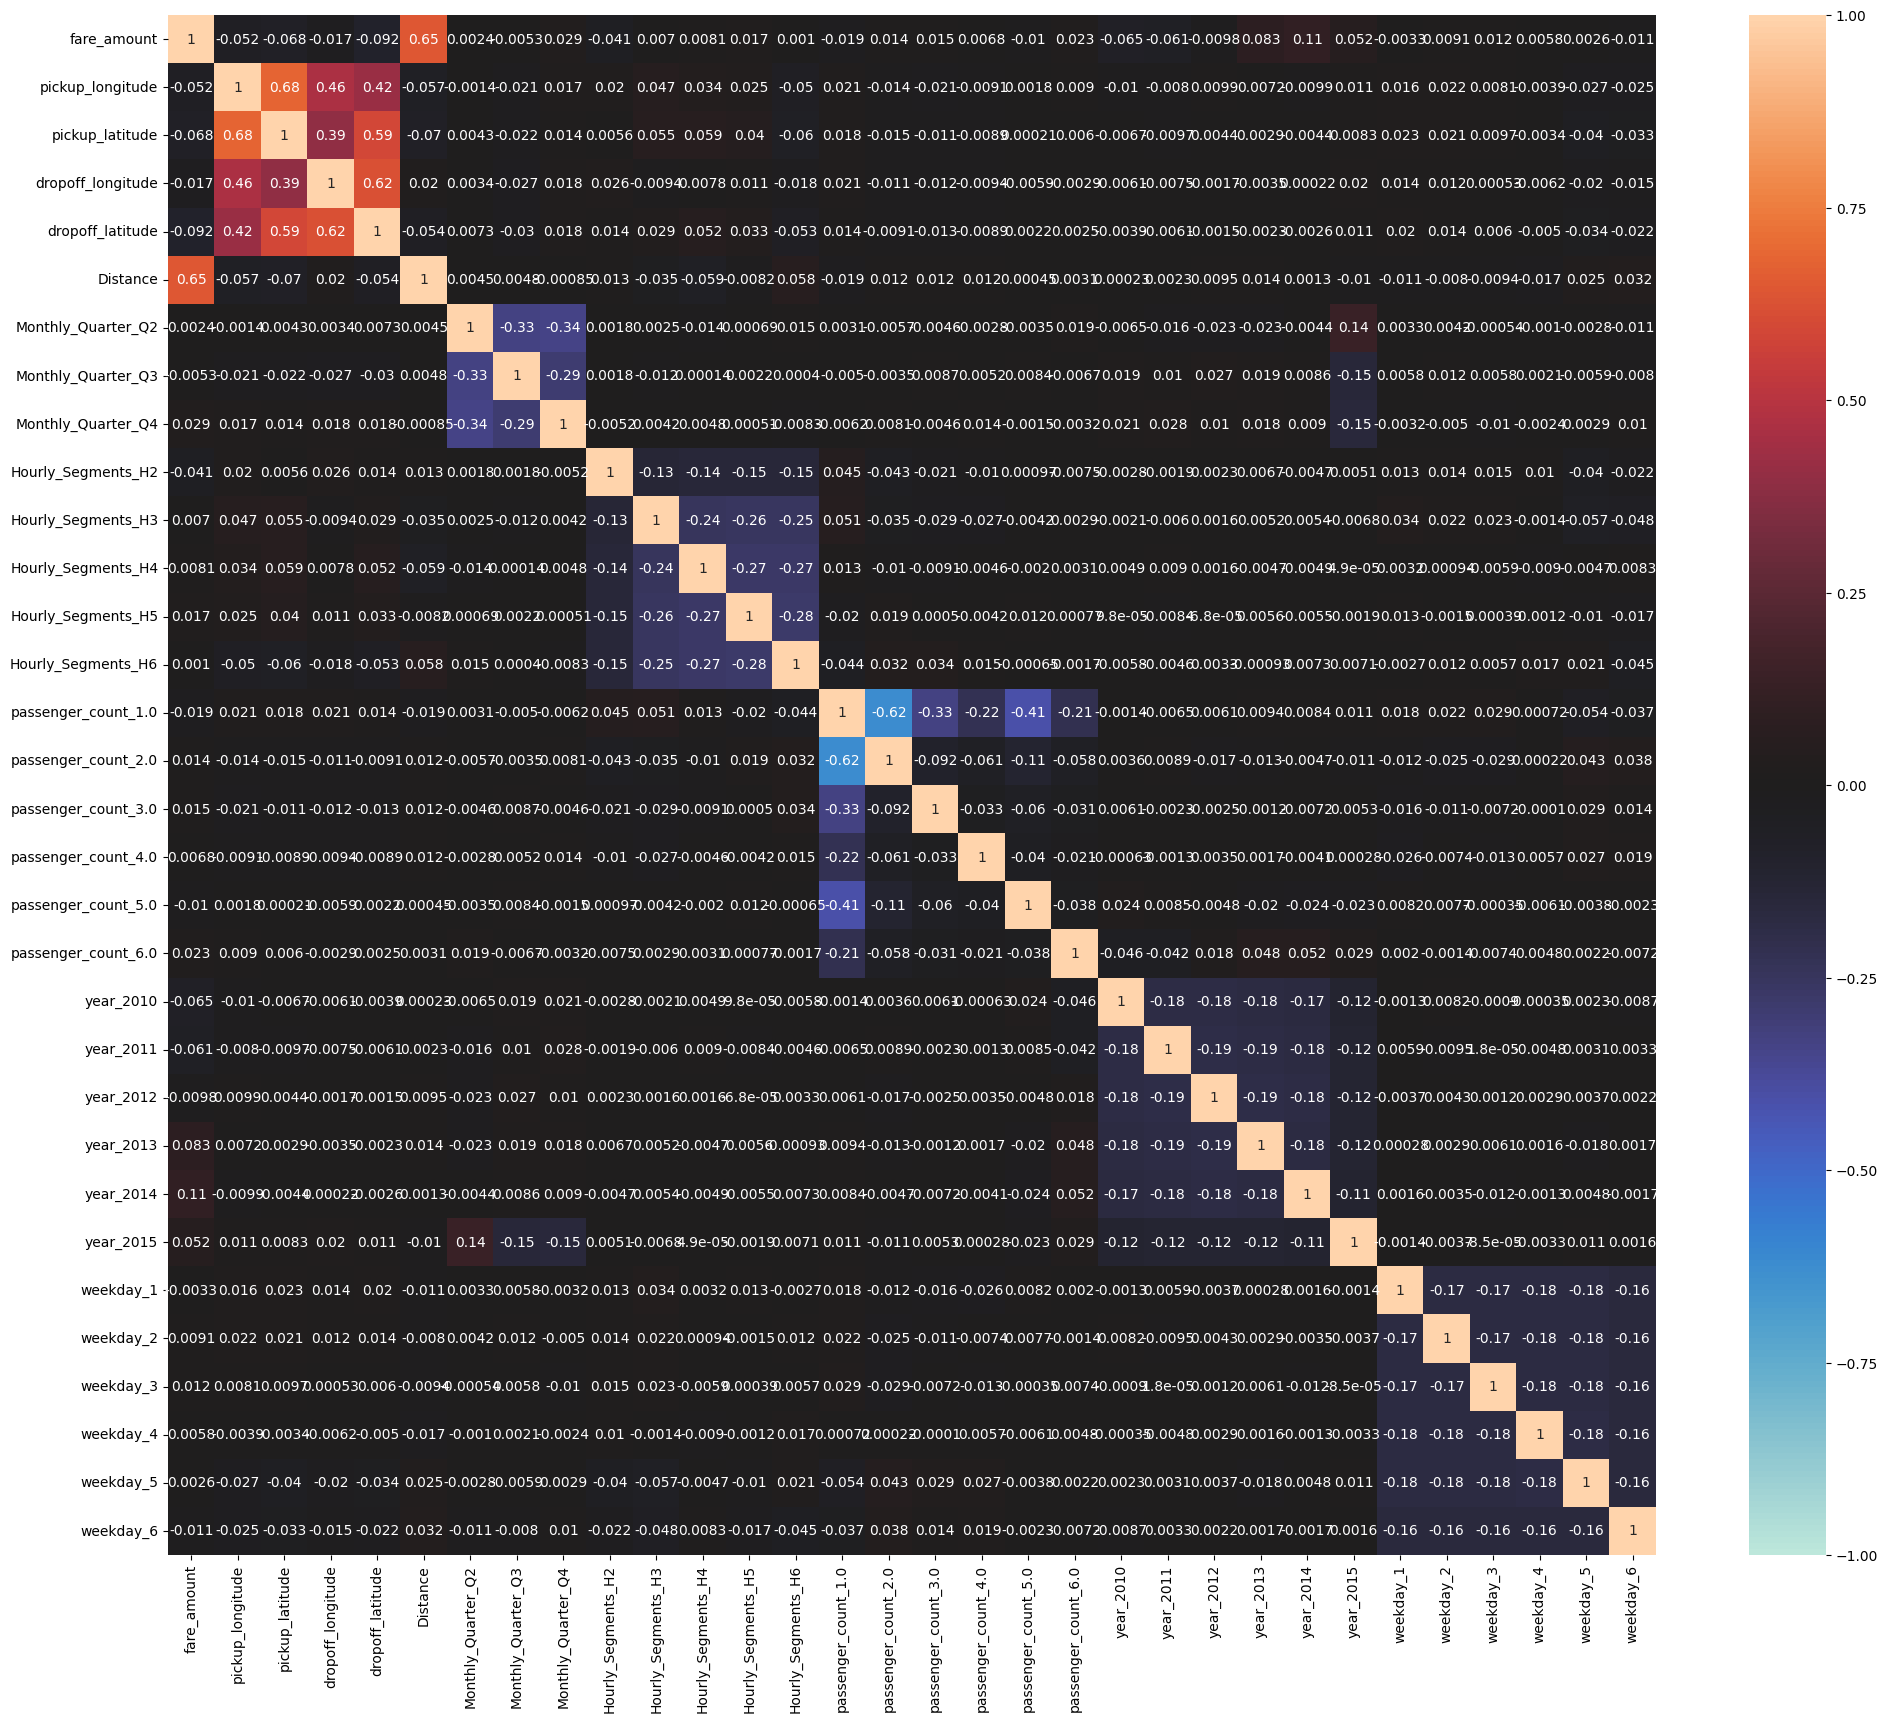

In [ ]:
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[24,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

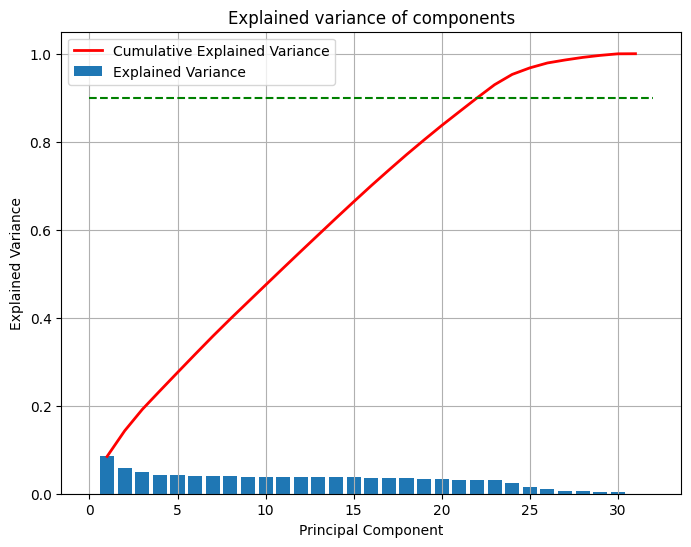

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

### Predictive Modelling

In [ ]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>50].columns,3)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

  #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))

    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')
    plt.xlabel('Errors')

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')
    plt.xlabel('y_test')
    plt.ylabel('y_pred')
    plt.show()

<<<------------------------- Evaluating Multiple Linear Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.03062602  0.05054888  0.08392707 -0.36733643  2.83459731  0.08137412
  0.08372747  0.22212828 -0.04374919  0.30791909  0.39897027  0.32015641
  0.07781891  0.06589624  0.10101797  0.07832522  0.03286071  0.03233833
  0.03704211  0.03006645  0.06971099  0.23409709  0.55452928  0.66258151
  0.48262257  0.07544839  0.12275815  0.14308357  0.12394147  0.01174124
 -0.0563011 ]
The Intercept of the Regresion Model was found to be  8.592026524064114


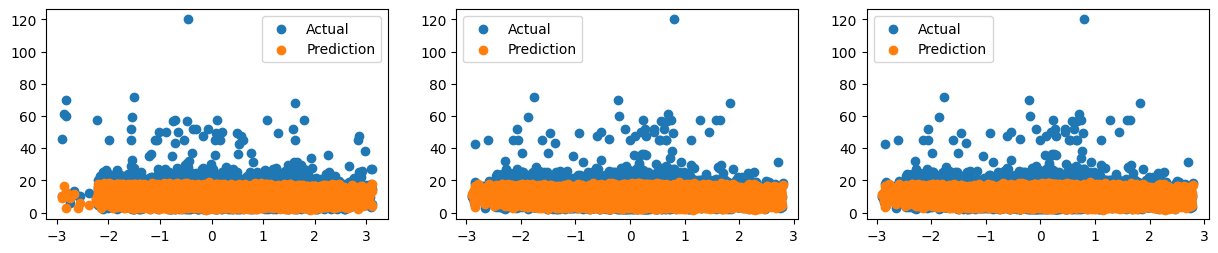



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.47193756068737513
Residual Sum of Squares (RSS) on Training set  ---> 231057.1960828981
Mean Squared Error (MSE) on Training set       ---> 9.884799832423449
Root Mean Squared Error (RMSE) on Training set ---> 3.1440101514504453

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.422338104994764
Residual Sum of Squares (RSS) on Training set  ---> 66563.63847490703
Mean Squared Error (MSE) on Training set       ---> 11.390081874556301
Root Mean Squared Error (RMSE) on Training set ---> 3.374919536012126

--------------------Residual Plots--------------------


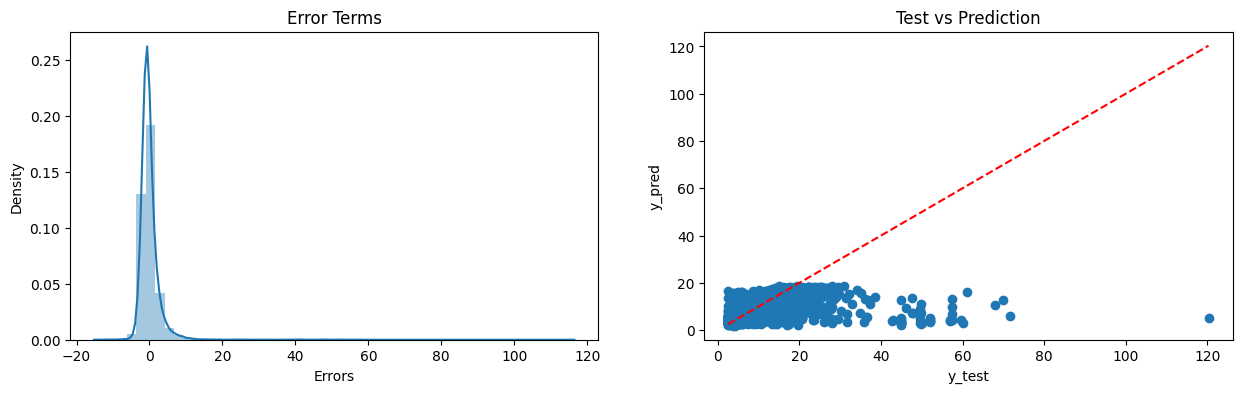

In [ ]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<------------------------- Evaluating Lasso Regression Model ------------------------->>>

The Coeffecient of the Regresion Model was found to be  [-0.         -0.         -0.         -0.          1.82530123  0.
 -0.          0.         -0.          0.          0.          0.
 -0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.        ]
The Intercept of the Regresion Model was found to be  8.59202652406417


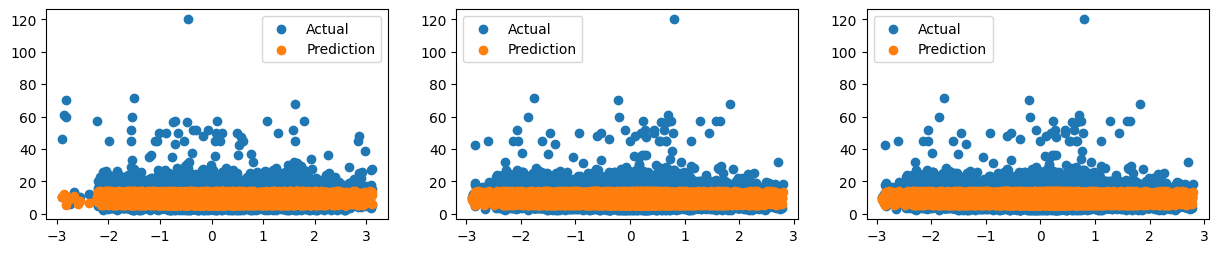



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.3730075185499162
Residual Sum of Squares (RSS) on Training set  ---> 274344.68718792533
Mean Squared Error (MSE) on Training set       ---> 11.736671109643865
Root Mean Squared Error (RMSE) on Training set ---> 3.425882530041546

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.3347267449316744
Residual Sum of Squares (RSS) on Training set  ---> 76659.04367292783
Mean Squared Error (MSE) on Training set       ---> 13.117563941294975
Root Mean Squared Error (RMSE) on Training set ---> 3.6218177675436647

--------------------Residual Plots--------------------


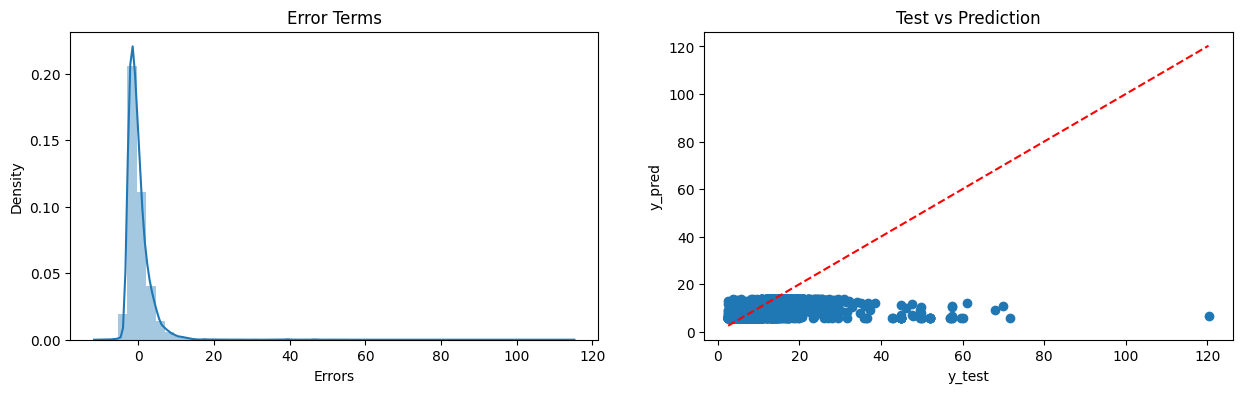

In [ ]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*25 ,'-'*25,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',LLR.coef_)
print('The Intercept of the Regresion Model was found to be ',LLR.intercept_)

Evaluate(2, pred1, pred2)